## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [47]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib qt

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all  the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('/home/soumya/edu/CarND-Advanced-Lane-Lines/camera_cal/calibration*.jpg')
print(len(images))
# Step through the list and search for chessboard corners
gray = []
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)


img = cv2.imread('/home/soumya/edu/CarND-Advanced-Lane-Lines/camera_cal/calibration1.jpg')
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

print (gray.shape)       
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
#print (ret, mtx, dist, rvecs, tvecs)
#img = cv2.imread('test_images/test1.jpg')

#dst = cv2.undistort(img, mtx, dist, None, mtx)



20


(720, 1280)


## And so on and so forth...

This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)
calling region_of_interest
masked_image  (720, 1280)
calling warper
(1280, 720)
[[  800.          417.6000061]
 [  400.          417.6000061]
 [  220.          720.       ]
 [ 1060.          720.       ]]
[[ 1060.     0.]
 [  220.     0.]
 [  220.   720.]
 [ 1060.   720.]]
(1280, 720)
[[  800.          417.6000061]
 [  400.          417.6000061]
 [  220.          720.       ]
 [ 1060.          720.       ]]
[[ 1060.     0.]
 [  220.     0.]
 [  220.   720.]
 [ 1060.   720.]]
in find_window_centroid  (720, 1280) 50 80 100
84.2615850948 m
84.2615850948 m


/home/soumya/.conda/envs/carnd-term1/lib/python3.5/site-packages/ipykernel_launcher.py:132: RankWarning: Polyfit may be poorly conditioned
/home/soumya/.conda/envs/carnd-term1/lib/python3.5/site-packages/ipykernel_launcher.py:132: RankWarning: Polyfit may be poorly conditioned


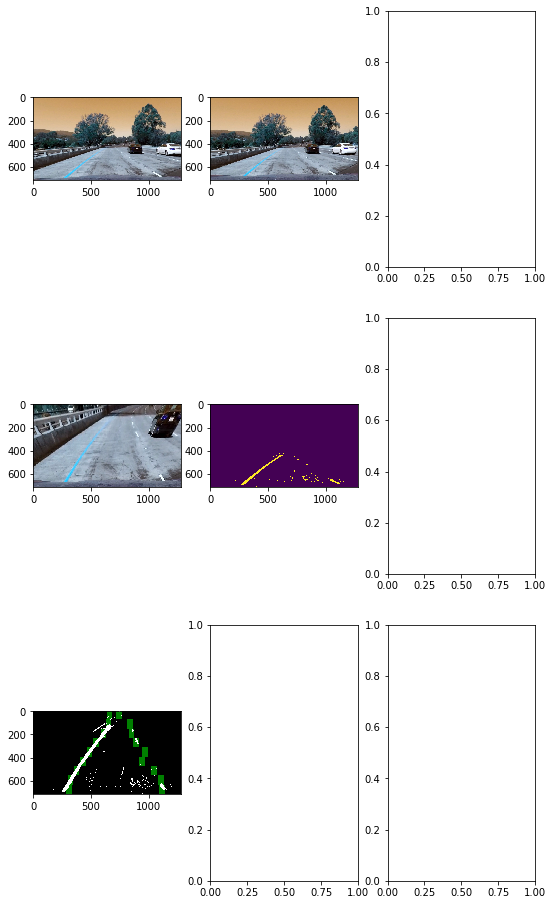

In [48]:
%matplotlib inline
def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    #plt.imshow(img)
    #plt.waitforbuttonpress()
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

def warper(img, src, dst):

    # Compute and apply perpectve transform
    img_size = (img.shape[1],img.shape[0])

    print (img_size)
    print (src)
    print (dst)
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_NEAREST)  # keep same size as input image
    return warped

def detect_lane(warped):
    #detect_lane using sliding window convolution method

# window settings
    window_width = 50 
    window_height = 80 # Break image into 9 vertical layers since image height is 720
    margin = 100 # How much to slide left and right for searching

    def window_mask(width, height, img_ref, center,level):
        output = np.zeros_like(img_ref)
        output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
        return output
    
    def find_window_centroids(image, window_width, window_height, margin):
        print ("in find_window_centroid ", image.shape, window_width, window_height, margin)
        window_centroids = [] # Store the (left,right) window centroid positions per level
        window = np.ones(window_width) # Create our window template that we will use for convolutions
        
        # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
        # and then np.convolve the vertical image slice with the window template 
        
        # Sum quarter bottom of image to get slice, could use a different ratio
        l_sum = np.sum(image[int(3*image.shape[0]/4):,:int(image.shape[1]/2)], axis=0)
        l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
        r_sum = np.sum(image[int(3*image.shape[0]/4):,int(image.shape[1]/2):], axis=0)
        r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(image.shape[1]/2)
        
        # Add what we found for the first layer
        window_centroids.append((l_center,r_center))
   
        # Go through each layer looking for max pixel locations
        for level in range(1,(int)(image.shape[0]/window_height)):
            # convolve the window into the vertical slice of the image
            image_layer = np.sum(image[int(image.shape[0]-(level+1)*window_height):int(image.shape[0]-level*window_height),:], axis=0)
            conv_signal = np.convolve(window, image_layer)
            # Find the best left centroid by using past left center as a reference
            # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
            offset = window_width/2
            l_min_index = int(max(l_center+offset-margin,0))
            l_max_index = int(min(l_center+offset+margin,image.shape[1]))
            l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
            # Find the best right centroid by using past right center as a reference
            r_min_index = int(max(r_center+offset-margin,0))
            r_max_index = int(min(r_center+offset+margin,image.shape[1]))
            r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
            # Add what we found for that layer
            window_centroids.append((l_center,r_center))
    
        return window_centroids

    window_centroids = find_window_centroids(warped, window_width, window_height, margin)

    # If we found any window centers
    if len(window_centroids) > 0:
    
        # Points used to draw all the left and right windows
        l_points = np.zeros_like(warped)
        r_points = np.zeros_like(warped)
    
        # Go through each level and draw the windows 	
        for level in range(0,len(window_centroids)):
            # Window_mask is a function to draw window areas
            l_mask = window_mask(window_width,window_height,warped,window_centroids[level][0],level)
            r_mask = window_mask(window_width,window_height,warped,window_centroids[level][1],level)
            # Add graphic points from window mask here to total pixels found 
            l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
            r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255
    
        # Draw the results
        template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
        zero_channel = np.zeros_like(template) # create a zero color channel
        template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
        warpage= np.dstack((warped, warped, warped))*255 # making the original road pixels 3 color channels
        output = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the orignal road image with window results
     
    # If no window centers found, just display orginal road image
    else:
        output = np.array(cv2.merge((warped,warped,warped)),np.uint8)
    return output,l_points,r_points

ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension
def curve_fit(ploty, plotx):
    # Define conversions in x and y from pixels space to meters
    print ("xm and ym per pix", xm_per_pix, ym_pre_pix)
    y_eval = np.min(ploty)
    # Fit new polynomials to x,y in world space
    fit_cr = np.polyfit(ploty*ym_per_pix, plotx*xm_per_pix, 2)
    fitx = fit_cr[0]*ploty**2 + fit_cr[1]*ploty + fit_cr[2]
    # Calculate the new radii of curvature
    curverad = ((1 + (2*fit_cr[0]*y_eval*ym_per_pix + fit_cr[1])**2)**1.5) / np.absolute(2*fit_cr[0])
    # Now our radius of curvature is in meters
    print(curverad, 'm')
    return ploty, fitx, curverad
    
    
def process_image(img):
    fig, axes = plt.subplots(3,3)
    
    #printing out some stats and plotting
    print('This image is:', type(img), 'with dimensions:', img.shape)
    # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')
    image_undist = cv2.undistort(img, mtx, dist, None, mtx)
    axes[0,0].imshow(image_undistort)
    axes[0,1].imshow(img)

    hls = cv2.cvtColor(image_undistort, cv2.COLOR_RGB2HLS)
    S = hls[:,:,2]
    thresh = (90, 255)
    s_binary = np.zeros_like(S)
    s_binary[(S > thresh[0]) & (S <= thresh[1])] = 1
    
    
    gray = cv2.cvtColor(image_undistort, cv2.COLOR_RGB2GRAY)    
    thresh_min = 20
    thresh_max = 100
    
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1,0, ksize = 3) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    
    #mask your edges and 
    imshape = combined_binary.shape
    
    vertices = np.array([[(10,imshape[0]),(imshape[1]/2-10, imshape[0]*0.58),
                          (imshape[1]/2+10, imshape[0]*0.58), (imshape[1]-10,imshape[0])]], dtype=np.int32)
    print ("calling region_of_interest")
    masked_image = region_of_interest(combined_binary, vertices) 
    print ("masked_image ", masked_image.shape)
    src_vertices = np.float32([
                    [800, imshape[0]*0.58], [400,imshape[0]*.58],
                    [220,imshape[0]],[imshape[1]-220, imshape[0]]])
   
    
    dst_vertices = np.float32([
                    [imshape[1]-220,0], [220,0],
                    [220,imshape[0]],[imshape[1]-220, imshape[0]]])

    print ("calling warper") 
    orig_warped = warper(img, src_vertices, dst_vertices)
    axes[1,0].imshow(orig_warped)
    axes[1,1].imshow(masked_image)
 
    warped = warper(masked_image, src_vertices, dst_vertices)
    # Display the final results
    lane_curve,l_points,r_points  = detect_lane(warped)

    axes[2,0].imshow(lane_curve)
    left_yplot, left_fitx, left_roc = curve_fit(l_points[0],l_points[1])
    right_yplot, right_fitx, right_roc = curve_fit(r_points[0],r_points[1])
    
    ploty = np.linspace(0, persp.shape[0]-1, persp.shape[0] )
    veh_offset = xm_per_pix * ((right_fitx[-1]+left_fitx[-1])/2  - persp.shape[1]/2)
    if veh_offset > 0:
        off_string = 'Vehicle is %4.3f m left of center' % (veh_offset)
    else:
        off_string = 'Vehicle is %4.3f m right of center' % (-veh_offset)
    roc = (lroc+rroc)/2
    rocstring = 'Radius of curvature = %5.3f km' % roc
    
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)
    result = cv2.putText(result, rocstring, (10, 30), cv2.FONT_HERSHEY_PLAIN, 2, (255,255,255))
    result = cv2.putText(result, off_string, (10, 60), cv2.FONT_HERSHEY_PLAIN, 2, (255,255,255))
    axes[].imshow('image',result) #WaitKey does not work without an image window
    plt.close('all')
img = cv2.imread('/home/soumya/edu/CarND-Advanced-Lane-Lines/test_images/test1.jpg')
process_image(img)

In [25]:

'''white_output = 'test_videos_output/solidWhiteRight.mp4'
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)
'''